# Simulation of a positron-induced Muon Source (part 1)


### Authors:
* Saverio Monaco
* Marianna Zeragic De Giorgio
* Gerardo Javier Carmona
* Hilario Capettini 

### Description

The production of a high brillance muon beam is one of the most important challenge for the future of Particle Physics. A particularly interesting idea consists of shooting high energy positrons on a target, aiming at the production of muons by means of the process $e^+ + e^- \rightarrow \mu^+ + \mu^-$. To mimize the divergence of the resulting "muon beam", the positrons energy is chosen so that the reaction occurs close to threshold (assuming the electrons in the target to be at rest). The main goal of this project is to produce a Monte Carlo simulation of such a process. 


### References

* [LEMMA](https://arxiv.org/pdf/1509.04454.pdf) paper. The original paper describing the positron-induced low emittance muon source, ehere all the relevant kinematic features of the process have been studied
* [Babayaga](https://www2.pv.infn.it/~hepcomplex/babayaga.html) event generator. You may want to install and run it as a comparison for your results.
* [2018 Experiment](https://arxiv.org/pdf/1909.13716.pdf): the paper describing the (very poor..) results of the experiment carried out in summer 2018
* [2021 proposal](https://cds.cern.ch/record/2712394?ln=en): the proposal for the experiment in 2021


### Contact

* Marco Zanetti <marco.zanetti@unipd.it>
* Camilla Curatolo <camilla.curatolo@pd.infn.it>
* Jacopo Pazzini <jacopo.pazzini@unipd.it>
* Alberto Zucchetta <alberto.zucchetta@pd.infn.it>

## Analytical part

1. Compute the process leading-order cross section, $\sigma(\theta; \sqrt{s})$, as a function of the scattering angle $\theta$ and with the  center of mass energy $\sqrt{s}$ as a parameter. Start by computing it in the center of mass system. N.B.: textbooks reports such cross section in the relativistic limit, i.e. for $\sqrt{s}\gg m_\mu$, which is clearly not the case here ($\sqrt{s}\sim 2m_\mu$);

2. compute and display the angle and momentum components distributions of the emerging muon pairs;

3. boost muons four-momenta in the laboratory frame, i.e. in the frame where the electron is at rest and the positron has enough energy to give rise to the process;

In [1]:
#ADD THEORETICAL RESULTS

In [2]:
#Import the required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.integrate as integrate
import csv
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import math

In [3]:
#Define the universal constants
muon_mass       = 0.1056583745       #[GeV]
electron_mass   = 0.00051099894      #[GeV]
alpha           = 0.007297           #[]            #CHECK
Avogadro_number = 6.02214076e23      #[#/mol]

The differential cross section we choosed is then $$\left(\frac{d\sigma}{d\Omega}\right)_{CM}=\frac{2\,\alpha^2}{s^2}\frac{|p'|}{\sqrt{s}}\left(\frac{s}{4}+p'^2\cos^2\vartheta+m_\mu^2\right)$$

The relativistic total energy is $$E_{CM}^2=4p'^2+4m_\mu^2\rightarrow p'^2=\frac{E_{CM}^2}{4}-m_\mu^2\rightarrow p'^2=\frac{s}{4}-m_\mu^2$$

Then our differential cross section becomes:
$$\left(\frac{d\sigma}{d\Omega}\right)_{CM}=\frac{2\,\alpha^2}{s}\sqrt{\frac{1}{4}-\frac{m_\mu^2}{s}}\left[\left(\frac{1}{4}+\frac{m_\mu^2}{s}\right)+\left(\frac{1}{4}- \frac{m_\mu^2}{s}\right)\cos^2{\theta}\right]$$

Integrating over the solid angle we obtain the total cross section:
$$\sigma(s)=\frac{8\pi\,\alpha^2}{3s}\sqrt{\frac{1}{4}-\frac{m_\mu^2}{s}}\left[1 + 2\frac{m_\mu^2}{s}\right]$$

In [4]:
#rs is the sqrt(s)= E
#The unis are Barn so 1ub = 2.56819e-3  GeV^-2      
gev_to_ub = 389.379

def cros_section(rs):
    # OLD y = np.pi * alpha**2 / (4*rs**2) * np.sqrt(1/4 - muon_mass**2 / rs**2) * (13/12 + 2/3 * muon_mass**2 / rs**2)
    y = 8 *np.pi * alpha**2 / (3*rs**2) * np.sqrt(1/4 - muon_mass**2 / rs**2) * (1 + 2 * muon_mass**2 / rs**2)
    return y * gev_to_ub
    
def dif_cross_section(rs,theta):
    # OLD y = alpha**2/(16 * rs**2)* np.sqrt(1/4 - muon_mass**2/rs**2) * (1 + muon_mass**2 / rs**2 + (1/4 -muon_mass**2/rs**2)*np.cos(theta)**2)
    y = 2 * alpha**2 / rs**2 * np.sqrt(1/4 - muon_mass**2 / rs**2) * (1/4 + muon_mass**2 / rs**2 + (1/4 - muon_mass**2 / rs**2)*np.cos(theta)**2)
    return y * gev_to_ub

def pdf_theta(rs,theta):
    y = 2*np.pi *np.sin(theta)*dif_cross_section(rs,theta)
    return y
    
def pdf_theta_normalized(rs,theta):
    y =pdf_theta(rs,theta)/cros_section(rs)
    return y




def pdf_p(rs,theta):
    y = 0
    return y
    
def pdf_p_normalized(rs,theta):
    y =pdf_p(rs,theta)/cros_section(rs)
    return y

In [5]:
#FUNCTIONS




In [6]:
#
###
####
#####
######
####### Analysis
######
#####
###
##
#

In [7]:
##################################################################################
#Analysis parameters
delta = 0.001
E = 2 * muon_mass + delta  #This is the proposed energy just above the threshold
N = 10**7

###################################################################################

In [8]:
print(np.sqrt(E**2/4-muon_mass**2))
print(E)
print(cros_section(E))

0.010291179451355442
0.212316749
0.27926780649750027


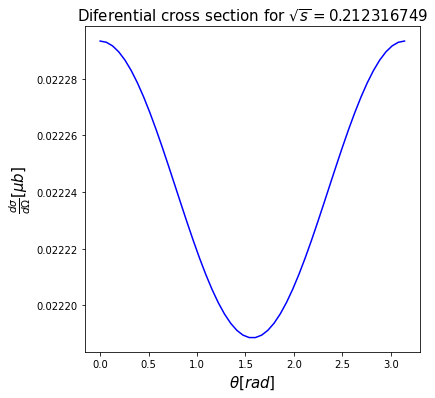

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
theta = np.linspace(0,np.pi)
ax.plot(theta, dif_cross_section(E,theta),color='blue', label='PDF')

plt.title(r'Diferential cross section for $\sqrt{s}=$'+str(E), fontsize=15)
plt.xlabel(r'$ \theta [rad] $', fontsize=15)
plt.ylabel(r'$ \frac{d\sigma}{d\Omega} [\mu b]$', fontsize=15)
#plt.legend()
plt.show()

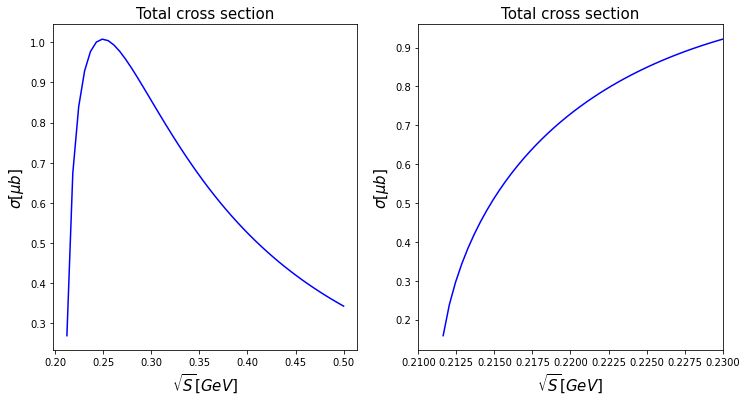

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
rs = np.linspace(0.2, 0.5)
ax1.plot(rs, cros_section(rs),color='blue', label='PDF')

ax1.set_title('Total cross section', fontsize=15)
ax1.set_xlabel(r'$ \sqrt{S} [GeV]$', fontsize=15)
ax1.set_ylabel(r'$ \sigma [\mu b]$', fontsize=15)
#plt.legend()

rs = np.linspace(0.21, 0.23)
ax2.plot(rs, cros_section(rs),color='blue', label='PDF')

ax2.set_title('Total cross section', fontsize=15)
ax2.set_xlabel(r'$ \sqrt{S} [GeV]$', fontsize=15)
ax2.set_ylabel(r'$ \sigma [\mu b]$', fontsize=15)
ax2.set_xlim(0.21,0.23)
plt.show()

Angle distribution


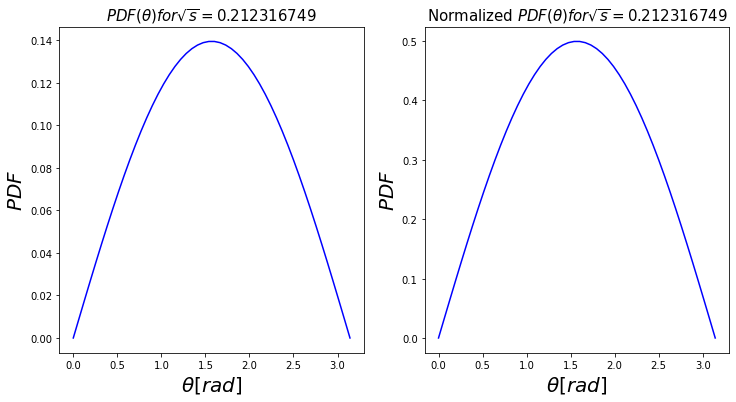

Check the normalization
Integral of the PDF in [0,pi] 0.27926780649750027

Integral of the normalized PDF in [0,pi] 1.0


In [11]:
print('Angle distribution')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

theta = np.linspace(0, np.pi)


ax1.plot(theta, pdf_theta(E,theta),color='blue', label='PDF')
ax1.set_title(r'$ PDF(\theta) for \sqrt{s}=$'+str(E), fontsize=15)
ax1.set_xlabel(r'$ \theta [rad] $', fontsize=20)
ax1.set_ylabel(r'$ PDF$', fontsize=20)
#plt.legend()



ax2.plot(theta, pdf_theta_normalized(E,theta),color='blue', label='PDF')
ax2.set_title(r'Normalized $ PDF(\theta) for \sqrt{s}=$'+str(E), fontsize=15)
ax2.set_xlabel(r'$ \theta [rad] $', fontsize=20)
ax2.set_ylabel(r'$ PDF$', fontsize=20)
plt.show()

print('Check the normalization')
x2 = lambda x: pdf_theta(E,x)
print('Integral of the PDF in [0,pi]',integrate.quad(x2, 0., np.pi)[0])
print('')
x2 = lambda x: pdf_theta_normalized(E,x)
print('Integral of the normalized PDF in [0,pi]',integrate.quad(x2, 0., np.pi)[0])

## Monte Carlo Simulation

4. write a Monte Carlo simulation that generates scattering events following the distrubtions that you found analytically; 
5. produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be listed as rows in a file with columns representing the muons coordinates (keep in mind that in the lab frame muons are relativistic and thus the number of coordinates can be only 3 per muon);


In [12]:
#
###
####
#####
######
#######
######
#####
###
##
#

In [13]:
def inv_cdf(rs,r):
    s = rs**2
    p = 3*(s+4*muon_mass**2)/(s-4*muon_mass**2)
    q = 4*(2*r-1)*(s+2*muon_mass**2)/(s-4*muon_mass**2)
    h = p**3/27+q**2/4
    cos_t = np.cbrt(-q/2+np.sqrt(h))+np.cbrt(-q/2-np.sqrt(h))
    rand_theta = np.arccos(cos_t)
    return rand_theta

def new_pdf_theta(rs,theta):
    s = rs**2
    y = 3/8*np.sin(theta)/(s+2*muon_mass**2)*((s-4*muon_mass**2)*np.cos(theta)**2+s+4*muon_mass**2)
    return y

In [14]:
#Inputs
#box = [0,np.pi,0.0,0.5] #Box coordinates [x0,x1,y0,y1] for analysis
                        #We choose the size to optimize the ammount of useful particles

In [15]:
## DEPRECATED
#def accept_reject(N,pdf,box,cm_energy):
#    x = np.random.uniform(box[0], box[1], N)
#    y = np.random.uniform(box[2], box[3], N)
#    
#    accepted = x[y<=pdf(cm_energy,x)]
#    return accepted
   

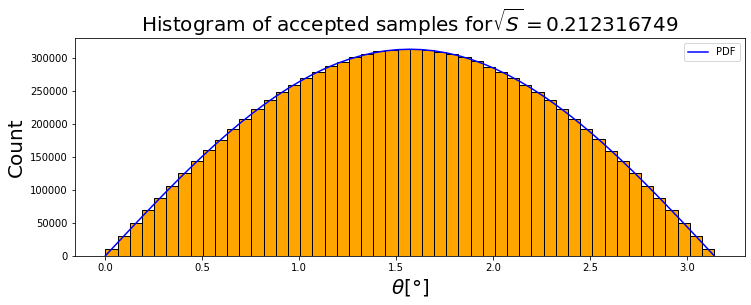

In [16]:
# Plot scaled histogram
fig, ax = plt.subplots(figsize=(12,4))

n, bins, _ = ax.hist(inv_cdf(E,np.random.random(N)), bins=50,color='orange', ec='black')

d = (bins[1]-bins[0])
scaling = d * n.sum()
ax.plot(bins, pdf_theta_normalized(E,bins)*scaling,color='blue', label='PDF')

plt.title('Histogram of accepted samples for'r'$ \sqrt{S}=$'+str(E), fontsize=20)
plt.xlabel(r'$ \theta [°]$', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.legend()
plt.show()

In [17]:
#Comparison with BabaYaga algorithm











In [18]:
#
###
####
#####
######
####### SIMULATION 1
######
#####
###
##
#

In [19]:
##################################################################################
#Simulation parameters

delta = 0.001
E = 2 * muon_mass + delta  #This is the proposed energy just above the threshold
N = 10**7

###################################################################################

In [20]:
#Obtain the parameters distribution
theta_instances = inv_cdf(E,np.random.random(N))
#N_instances     = len(theta_instances)
phi_instances   = np.random.uniform(0., 2*np.pi, N)

p = np.sqrt(E**2/4-muon_mass**2)

In [21]:
#Obtain the muons momenta and build the file  (Is it in the CoM frame?)

pxm = p * np.sin(theta_instances)*np.cos(phi_instances)
pym = p * np.sin(theta_instances)*np.sin(phi_instances)
pzm = p * np.cos(theta_instances)

pxam = -pxm
pyam = -pym
pzam = -pzm

#df = pd.DataFrame({'Theta' : theta_instances,'Phi' : phi_instances,'Muon px' : pxm, 'Muon py' : pym, 'Muon pz' : pzm})
#df.to_csv('/muons_momentum_com.csv', index=False)

In [22]:
#Check the file
print(r'$\sqrt(s)$',E)
print('')
print('Norm of p =',p)
#file_name='muons_momentum_com.csv'
#data=pd.read_csv(file_name)
#data

$\sqrt(s)$ 0.212316749

Norm of p = 0.010291179451355442


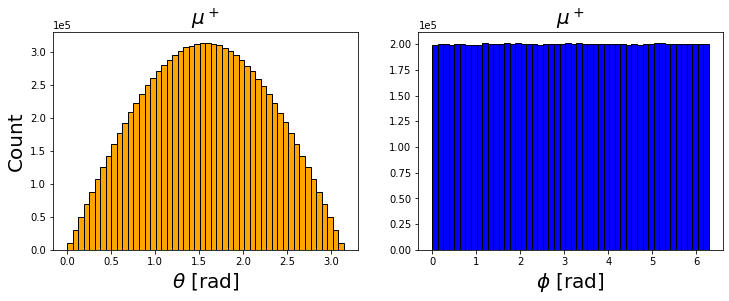

In [23]:
#Angular distribution (Insert some diagram with polar coordinates and the beam)




fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

n, bins, _ = ax1.hist(theta_instances, bins=50,color='orange', ec='black')
ax1.set_title(r'$\mu^+$', fontsize=20)
ax1.set_xlabel(r'$\theta$ [rad]', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

n, bins, _ = ax2.hist(phi_instances, bins=50,color='blue', ec='black')
ax2.set_title(r'$\mu^+$', fontsize=20)
ax2.set_xlabel(r'$\phi$ [rad]', fontsize=20)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

plt.show()

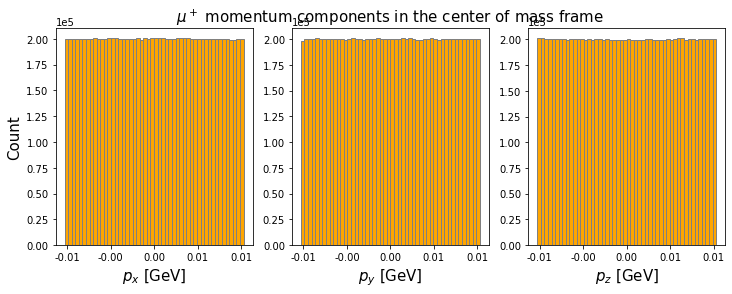

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

n, bins, _ = ax1.hist(pxm, bins=50,color='orange', ec='grey')
ax1.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax2.hist(pym, bins=50,color='orange', ec='grey')
ax2.set_title(r'$\mu^+$ momentum components in the center of mass frame', fontsize=15)
ax2.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



n, bins, _ = ax3.hist(pzm, bins=50,color='orange', ec='grey')
ax3.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



plt.show()

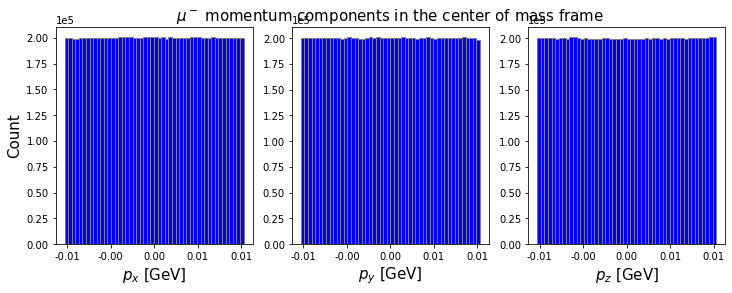

In [25]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

n, bins, _ = ax1.hist(pxam, bins=50,color='b', ec='grey')
ax1.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

n, bins, _ = ax2.hist(pyam, bins=50,color='blue', ec='grey')
ax2.set_title(r'$\mu^-$ momentum components in the center of mass frame', fontsize=15)
ax2.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax3.hist(pzam, bins=50,color='blue', ec='grey')
ax3.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.show()

In [26]:
#Inser Pandas table with some statistics




In [27]:
#THEORY, what Saverio wrote but in the other frame with the electron moving toward the CM wit V=Vz


The Lab frame is the frame where the electrons are at rest (in a target), in order to transpose the problem in this other frame, it is important to consider special relativity in the calculations, being the electron and positron highly energetic (in order to produce the muon pair)

The generic boost in a frame moving with velocity $u$ in the z direction is:

$$\Lambda = \left(\begin{array}{c}
           \gamma & 0 & 0 & -u\gamma \\
           0 & 1  & 0 & 0 \\
           0    &  0      & 1 & 0 \\
           -u\gamma     &  0       & 0 & \gamma \\ 
\end{array}\right)$$

In our case since the velocity is negative, the Lorentz Matrix for the electron moving at velocity $v$ in the CoM frame is:

$$\Lambda = \left(\begin{array}{c}
           \gamma & 0 & 0 & v\gamma \\
           0 & 1  & 0 & 0 \\
           0    &  0      & 1 & 0 \\
           v\gamma     &  0       & 0 & \gamma \\ 
\end{array}\right)$$

Since the electron in moving exclusively in the $z$ direction in the CoM frame, we can derive it's velocity from the definition of relativistic momentum:
$$p=m_e\gamma v\to v\gamma = \frac{p}{m_e}\to \frac{v}{\sqrt{1-v^2}}=\frac{p}{m_e}\to v= \frac{p}{m_e\sqrt{1+\frac{p^2}{m_e^2}}}=\frac{p}{\sqrt{m_e^2 + p^2}}$$

Notice that the energy of the particle in the COM is $E_p=\sqrt{m_e^2+p^2}$ (the denominator)

$$\begin{cases}E_p^2=m_e^2+p^2\\ E^2_{CM}=4m_e^2+4p^2\end{cases}$$

then v becomes:
$$v=\sqrt{  \frac{E^2_{CM}-4m_e^2}{E^2_{CM}}  }$$

In [28]:
################################################

To boost from the CoM frame to the Lab frame the Lorentz matrix is the following:

$$\Lambda = \left(\begin{array}{c}
           \gamma & 0 & 0 & v\gamma \\
           0 & 1  & 0 & 0 \\
           0    &  0      & 1 & 0 \\
           v\gamma     &  0       & 0 & \gamma \\ 
\end{array}\right),\qquad\qquad v=\sqrt{  \frac{E^2_{CM}-4m_e^2}{E^2_{CM}}  }$$

To get the momenta of the muons in the Lab frame we need to apply the Lorentz matrix to their 4-momenta:

$$\Lambda^\mu_\nu P^\nu = P'^\mu$$

Where $P^\nu$ is the 4 momentum before the boosting (in the COM frame) and $P'^\nu$ is the 4 momentum after the boosting (in the LAB frame)

$$P=\left(\begin{array}{c}m\gamma \\ 0 \\ p\sin\vartheta \\ p\cos\vartheta\end{array}\right)$$

$$P'=\left(\begin{array}{c}
           \gamma & 0 & 0 & v\gamma \\
           0 & 1  & 0 & 0 \\
           0    &  0      & 1 & 0 \\
           v\gamma     &  0       & 0 & \gamma \\ 
\end{array}\right)\left(\begin{array}{c}m\gamma \\ 0 \\ p\sin\vartheta \\ p\cos\vartheta\end{array}\right)=\left(\begin{array}{c}m\gamma^2 + \gamma vp\cos\vartheta \\ 0 \\ p\sin\vartheta\\ m\gamma^2 v + \gamma p\cos\vartheta \end{array}\right)$$

From here we can get the relationship $\vartheta\leftrightarrow\vartheta'$ the angle of the scattered particle before and after the boosts:

$$\begin{cases}
    m\gamma^2v+\gamma p\cos\vartheta = p'\cos\vartheta' \\
    p\sin\vartheta = p\sin\vartheta'
\end{cases}$$

Writing $m\gamma^2 v$ as $\gamma p$ we have

$$\begin{cases}
    \gamma p +\gamma p\cos\vartheta = p'\cos\vartheta' \\
    p\sin\vartheta = p\sin\vartheta'
\end{cases}$$

Dividing the first to the second we get:
 $$\tan\vartheta'=\frac{1}{\gamma}\left(\frac{\sin\vartheta}{1+\cos\vartheta}\right)$$

In [29]:
#Boost the results to the laboratory frame

vz = -np.sqrt(1-4*electron_mass**2/E**2)   
gamma = 1/np.sqrt(1-vz**2)

In [30]:
print('gamma',gamma)
print('vz',vz)

gamma 207.74676068826517
vz -0.9999884147876493


In [31]:
pxm_lb = pxm
pym_lb = pym
pzm_lb = gamma * pzm - vz * gamma *E 

pxam_lb = pxam 
pyam_lb = pyam
pzam_lb = gamma * pzam - vz * gamma *E

#df = pd.DataFrame({'Theta' : theta_instances,'Phi' : phi_instances,'Muon px' : pxm_lb, 'Muon py' : pym_lb, 'Muon pz' : pzm_lb})
#df.to_csv('/home/usuario/PoD/muons_momentum_lab.csv', index=False)

In [33]:
#Check the file
print(r'$\sqrt(s)$',E)
print('')
print('Norm of p =',p)
#file_name='/home/usuario/PoD/muons_momentum_lab.csv'
#data=pd.read_csv(file_name)
#data

$\sqrt(s)$ 0.212316749

Norm of p = 0.010291179451355442


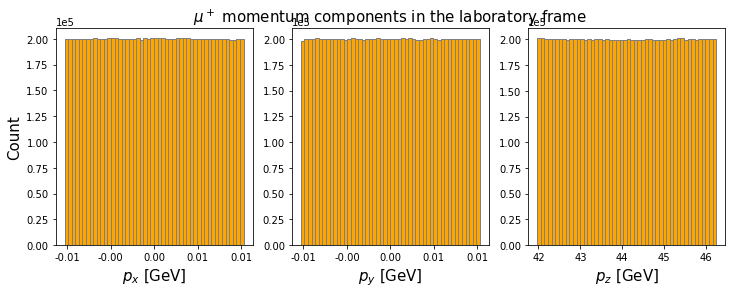

In [34]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

n, bins, _ = ax1.hist(pxm_lb, bins=50,color='orange', ec='grey')
ax1.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax2.hist(pym_lb, bins=50,color='orange', ec='grey')
ax2.set_title(r'$\mu^+$ momentum components in the laboratory frame', fontsize=15)
ax2.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



n, bins, _ = ax3.hist(pzm_lb, bins=50,color='orange', ec='grey')
ax3.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
#ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))



plt.show()

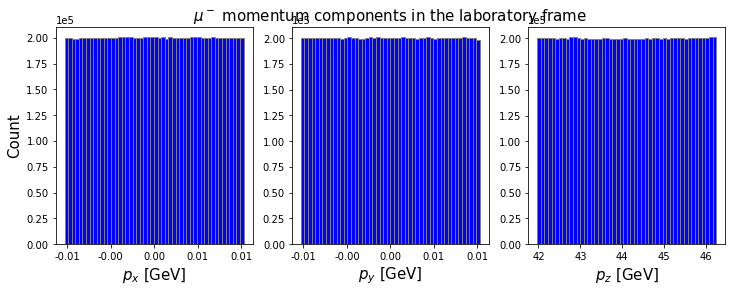

In [35]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

n, bins, _ = ax1.hist(pxam_lb, bins=50,color='blue', ec='grey')
ax1.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax2.hist(pyam_lb, bins=50,color='blue', ec='grey')
ax2.set_title(r'$\mu^-$ momentum components in the laboratory frame', fontsize=15)
ax2.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



n, bins, _ = ax3.hist(pzam_lb, bins=50,color='blue', ec='grey')
ax3.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))



plt.show()

In [36]:
#Inser Pandas table with some statistics






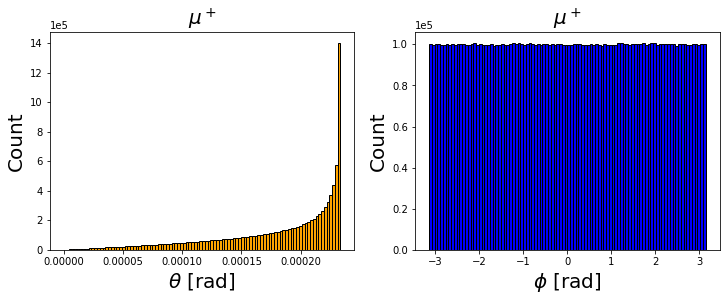

In [37]:
#Reconstruction of the angular distribution from the momenta
#It means that the beam is concentrated in an arc of 0.04°
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

theta_lb = np.arccos(pzm_lb/np.sqrt(pxm_lb**2+pym_lb**2+pzm_lb**2))

n, bins, _ = ax1.hist(theta_lb, bins=100,color='orange', ec='black')
ax1.set_title(r'$\mu^+$', fontsize=20)
ax1.set_xlabel(r'$\theta$ [rad]', fontsize=20)
ax1.set_ylabel('Count', fontsize=20)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))


phi_lb = np.arctan2(pym_lb,pxm_lb)

n, bins, _ = ax2.hist(phi_lb, bins=100,color='blue', ec='black')
ax2.set_title(r'$\mu^+$', fontsize=20)
ax2.set_xlabel(r'$\phi$ [rad]', fontsize=20)
ax2.set_ylabel('Count', fontsize=20)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

plt.show()


In [38]:
p_cm = -E**2 + pxm**2+pym**2+pzm**2
print('Squared four momentum in the CM frame',p_cm)

E_lb = gamma*(E-pzm*vz)
p_lb = -E_lb**2 + pxm_lb**2+pym_lb**2+pzm_lb**2
print('Squared four momentum in the LB frame',p_lb)

print('Muon energy in the laboratory frame',E_lb)

Squared four momentum in the CM frame [-0.04497249 -0.04497249 -0.04497249 ... -0.04497249 -0.04497249
 -0.04497249]
Squared four momentum in the LB frame [-0.04497249 -0.04497249 -0.04497249 ... -0.04497249 -0.04497249
 -0.04497249]
Muon energy in the laboratory frame [44.30849071 44.93822165 43.75622677 ... 45.17487813 45.36463413
 44.946796  ]


In [39]:
#Inser 3d plot of a sphere with a heatmam

In [40]:
#
###
####
#####
######
#######
######
#####
###
##
#

## Introduce somo realistic properties to the target 
6. assume a $3$ cm thick Beryllium block is used as target and a rate of positron on target of $10^6$ Hz. Compute the rescaling factor (weight) you need to apply to the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations;


In [41]:
#Write some theory, basically we use the theory of poitn 3 LEMMA paper (Antonelli)





In [42]:
#Realistic target
positron_frequency = 1.e6                    #[Hz]
target_length      = 3                       #[cm]
Beryllium_aw       = 9.0121831               #[g/mol]
Beryllium_e        = 4
X0                 = 35.2                    #[cm]              #Beryllium radiation lengt
cs                 = cros_section(E)*10.e-31 #[uBarn]--> [cm^2]

time               = 60 * 60 *24 *7          #[secconds]

In [43]:
#Electron density in the target
Beryllium_density = Avogadro_number / Beryllium_aw
electron_density  = Beryllium_e * Beryllium_density

#Number of positrons 
N_positrons = positron_frequency * time 

#Number of muons
N_muons = N_positrons * electron_density * cs * target_length

rf = N_muons/N

print('Number of positrons in a week                     '"{:.2e}".format( N_positrons))
print('')
print('Number of muons produced in a week with this beam '"{:.2e}".format( N_muons))
print('')
print('Number of events simulated                        '"{:.2e}".format( N))
print('')
print('Number of muons produced                          '"{:.2e}".format( np.sum(n)))
print('')
print('Rescaling factor', rf)
print('')
print('Real number of muons produced after a week        '"{:.2e}".format( rf*np.sum(n)))

Number of positrons in a week                     6.05e+11

Number of muons produced in a week with this beam 1.35e+05

Number of events simulated                        1.00e+07

Number of muons produced                          1.00e+07

Rescaling factor 0.013543621187272986

Real number of muons produced after a week        1.35e+05


In [44]:
#
###
####
#####
######
####### 
######
#####
###
##
#

## Introduce somo realistic properties to  the beam
7. repeat what done so far simulating now the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV;

In [45]:
##################################################################################
#Simulation parameters

N = 10**7  #Number of positrons
E_lab = 45  #GeV
sigma = 0.5 # mean and standard deviation

###################################################################################

In [46]:
#Realistic beam
#Up to this point we have been asuming that the energy of the incident 
#beam had a constant value, now we want to make a model where the energy
#of the beam has a gaussian distribution.

E_lab_instances = np.random.normal(E_lab, sigma, N)

#Now we need to boost them to the CoM frame
vz    = np.sqrt((E_lab-electron_mass)/(E_lab+electron_mass))   
gamma = 1/np.sqrt(1-vz**2)

E_cm_instances = 2 *gamma*(E_lab_instances-vz*np.sqrt(E_lab_instances**2-electron_mass**2))

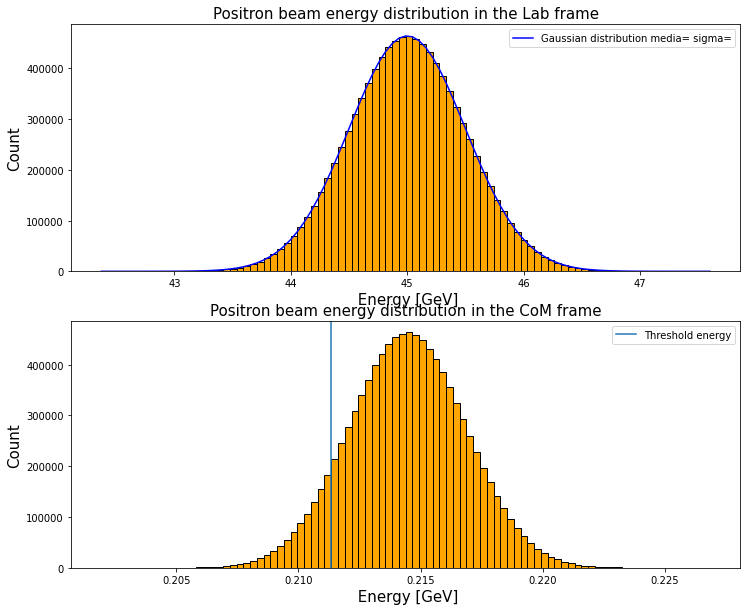

In [47]:
# Plot scaled histogram
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

n, bins, _ = ax1.hist(E_lab_instances, bins=90,color='orange', ec='black')

d = (bins[1]-bins[0])
scaling = d * n.sum()

ax1.plot(bins, scaling/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - E_lab)**2 / (2 * sigma**2) ),color='blue', label='Gaussian distribution media= sigma=')

ax1.set_title('Positron beam energy distribution in the Lab frame', fontsize=15)
ax1.set_xlabel(' Energy [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
ax1.legend()

n, bins, _ = ax2.hist(E_cm_instances, bins=90,color='orange', ec='black')

d = (bins[1]-bins[0])
scaling = d * n.sum()

ax2.axvline(x=2*muon_mass, label='Threshold energy')
#ax2.plot(bins, scaling/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - E_lab)**2 / (2 * sigma**2) ),color='blue', label='PDF')
ax2.set_title('Positron beam energy distribution in the CoM frame', fontsize=15)
ax2.set_xlabel(' Energy [GeV]', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.legend()




plt.show()

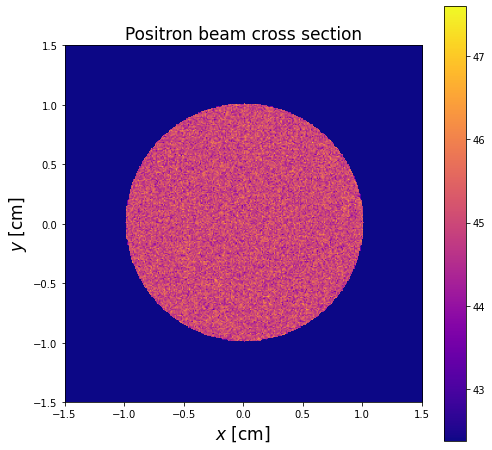

In [48]:
#Once we have the energy distribution plot a heatmap of the beam

def circular_section(data):
    
    # specify circle parameters: centre ij and radius
    pixels =len(data[0,:])
    ci,cj = pixels/2 , pixels/2
    cr=pixels/3

    # Create index arrays to z
    I,J=np.meshgrid(np.arange(data.shape[0]),np.arange(data.shape[1]))

    # calculate distance of all points to centre
    dist=np.sqrt((I-ci)**2+(J-cj)**2)

    # Assign value of 1 to those points where dist<cr:
    data[np.where(dist>cr)]=0
    return data



pixels=300
size  =(-1.5,1.5,-1.5,1.5)

# We randomly pick (pixel x pixels) elements of the energy distribution to plot the beam cross section

z = np.random.choice(E_lab_instances, size=(pixels,pixels), replace=True, p=None) 


plt.rcParams["figure.figsize"] = (8,8)
plt.imshow(circular_section(z),cmap='plasma', extent=(size),origin='lower')
plt.title('Positron beam cross section',fontsize=17)
plt.ylabel(r'${y}$ [cm]',fontsize=17)  
plt.xlabel(r'${x}$ [cm]',fontsize=17)
plt.colorbar()
plt.clim(np.min(E_lab_instances),np.max(E_lab_instances))
plt.show()

In [49]:
#
###
####
#####
######
####### SIMULATION 2
######
#####
###
##
#

In [50]:
##################################################################################
#Simulation parameters

N     = 10**4 #Number of positrons 
E_lab = 45    #GeV
sigma = 0.5   # mean and standard deviation

###################################################################################

In [51]:
##Now that we have the energy distributions and also an idea of the shape
##we can repeat the previous part

#Obtain the positron energy samples in the laboratory frame
E_lab_samples = np.random.normal(E_lab, sigma, N)

#Boost of the positrons energy to the Center of Mass Frame
vz    = np.sqrt((E_lab-electron_mass)/(E_lab+electron_mass))   
gamma = 1/np.sqrt(1-vz**2)

E_cm_samples = 2 *gamma*(E_lab_samples-vz*np.sqrt(E_lab_samples**2-electron_mass**2))

#Filter the values below the threshold
E_cm_samples = E_cm_samples[E_cm_samples> 2* muon_mass]

N_instances = len(E_cm_samples)

#######################
# DEPRECATED
#EXTREMELY INEFICIENT METHOD TO GET THETA takes around 25 minutes for 10**5 positrons
#theta_cm_instances = np.arange(0,0)
#for i in range(0,N_instances):
#    theta_cm_instances = np.append(theta_cm_instances,np.random.choice(accept_reject(10**5,#pdf_theta_normalized,box,E_cm_samples[i])))

theta_cm_instances = inv_cdf(E_cm_samples,np.random.random(N_instances))

phi_cm_instances   = np.random.uniform(0., 2*np.pi, N_instances)

In [52]:
#Calculate the total momentum p       CM
#Calculate the momentum components in CM
p_cm_instances = np.sqrt(E_cm_samples**2/4-muon_mass**2)

pxm_cm = p_cm_instances * np.sin(theta_cm_instances)*np.cos(phi_cm_instances)
pym_cm = p_cm_instances * np.sin(theta_cm_instances)*np.sin(phi_cm_instances)
pzm_cm = p_cm_instances * np.cos(theta_cm_instances)

#Calculate the momentum components in LAB
vz = -np.sqrt(1-4*electron_mass**2/E_cm_samples**2)   
gamma = 1/np.sqrt(1-vz**2)

pxm_lb = pxm_cm
pym_lb = pym_cm
pzm_lb = gamma * pzm_cm - vz * gamma *E_cm_samples 

#Calculate the total momentum p       LAB
#Obtain the angles thet and phi       LAB
p_lb_instances = np.sqrt(pxm_lb**2 + pym_lb**2 + pzm_lb**2)

theta_lb_instances = np.arccos(pzm_lb/p_lb_instances)
phi_lb_instances   = np.arctan2(pym_lb,pxm_lb)

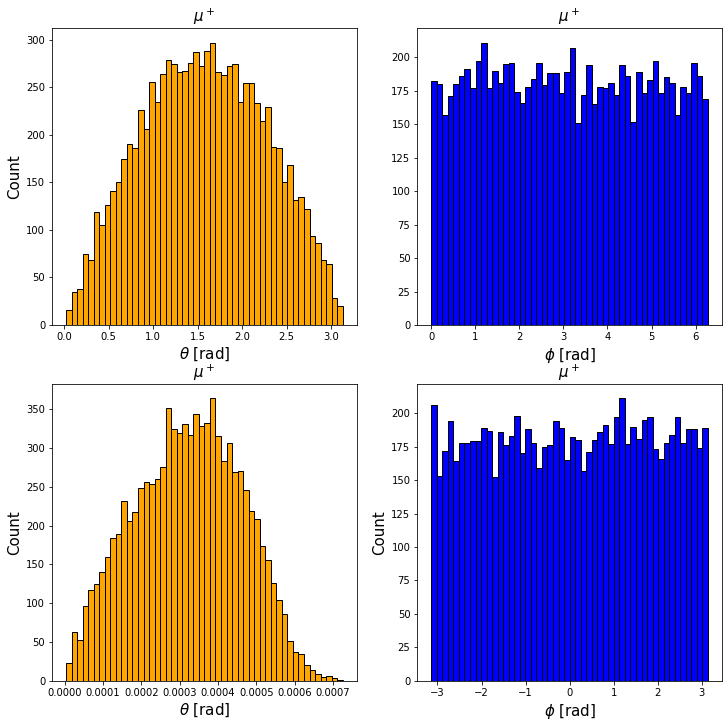

In [53]:
#Plot of the spherical angle  distributions in each frame

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

n, bins, _ = ax1.hist(theta_cm_instances, bins=50,color='orange', ec='black')
ax1.set_title(r'$\mu^+$', fontsize=15)
ax1.set_xlabel(r'$\theta$ [rad]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
#ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

n, bins, _ = ax2.hist(phi_cm_instances, bins=50,color='blue', ec='black')
ax2.set_title(r'$\mu^+$', fontsize=15)
ax2.set_xlabel(r'$\phi$ [rad]', fontsize=15)
#ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

n, bins, _ = ax3.hist(theta_lb_instances, bins=50,color='orange', ec='black')
ax3.set_title(r'$\mu^+$', fontsize=15)
ax3.set_xlabel(r'$\theta$ [rad]', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
#ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

n, bins, _ = ax4.hist(phi_lb_instances, bins=50,color='blue', ec='black')
ax4.set_title(r'$\mu^+$', fontsize=15)
ax4.set_xlabel(r'$\phi$ [rad]', fontsize=15)
ax4.set_ylabel('Count', fontsize=15)
#ax4.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

plt.show()

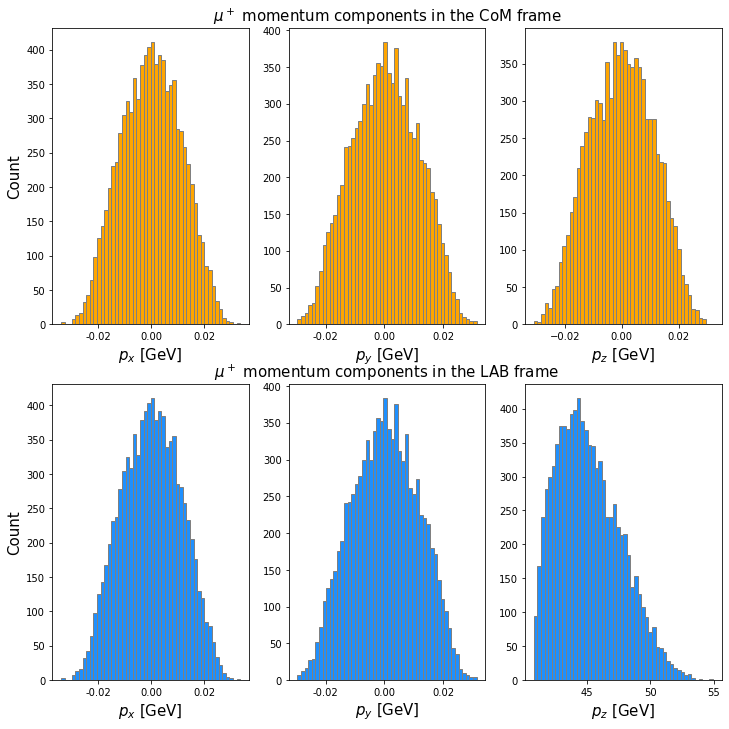

In [54]:
#Momentum distribution in the LAB frame
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))

n, bins, _ = ax1.hist(pxm_cm, bins=50,color='orange', ec='grey')
ax1.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
#ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax2.hist(pym_cm, bins=50,color='orange', ec='grey')
ax2.set_title(r'$\mu^+$ momentum components in the CoM frame', fontsize=15)
ax2.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
#ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



n, bins, _ = ax3.hist(pzm_cm, bins=50,color='orange', ec='grey')
ax3.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
#ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
#ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))


n, bins, _ = ax4.hist(pxm_lb, bins=50,color='dodgerblue', ec='grey')
ax4.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax4.set_ylabel('Count', fontsize=15)
#ax4.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax5.hist(pym_lb, bins=50,color='dodgerblue', ec='grey')
ax5.set_title(r'$\mu^+$ momentum components in the LAB frame', fontsize=15)
ax5.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
#ax5.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax5.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



n, bins, _ = ax6.hist(pzm_lb, bins=50,color='dodgerblue', ec='grey')
ax6.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
#ax6.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
#ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))



plt.show()

In [55]:
#I would like to plot a sphere with a heatmap showing the muons distribution

## Aditional considerations

8. given that the electrons traversing the target lose energy as $E(z)=E_0 \exp{-z/X_0}$ (with z the longitudinal coordinate of the target, the one parallel to the beam direction and $X_0$ is the Beryllium radiation length), compute the nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target;
9. (optional) take the former point into account when generating the events (i.e. the proccess $\sqrt{s}$ depend on the position along the target where the $e^+ - e^-$ scattering occurrs.



In [56]:
#
###
####
#####
######
####### SIMULATION 3
######
#####
###
##
#

In [57]:
##################################################################################
#Simulation parameters

N     = 10**4 #Number of positrons 
sigma = 0.5   # mean and standard deviation

###################################################################################

In [58]:
E0_cm = 2 *muon_mass/np.exp(-target_length/X0)
print('Nominal beam energy in the CoM frame',E0_cm, 'GeV')

vz = -np.sqrt(1-4*electron_mass**2/E0_cm**2)   
gamma = 1/np.sqrt(1-vz**2)
p = np.sqrt(E0_cm**2/4-muon_mass**2)
pzm = p * np.cos(0)                                       #Where does p come from?#####
E0_lb = gamma*(E0_cm-pzm*vz)
print('Nominal beam energy in the Lab frame',E0_lb, 'GeV')

Nominal beam energy in the CoM frame 0.23011644436478307 GeV
Nominal beam energy in the Lab frame 62.06962558183501 GeV


In [59]:
E_lab = E0_lb    #GeV

#Obtain the positron energy samples in the laboratory frame
E_lab_samples = np.random.normal(E_lab, sigma, N)

#Boost of the positrons energy to the Center of Mass Frame
vz    = np.sqrt((E_lab-electron_mass)/(E_lab+electron_mass))   
gamma = 1/np.sqrt(1-vz**2)

E_cm_samples = 2 *gamma*(E_lab_samples-vz*np.sqrt(E_lab_samples**2-electron_mass**2))

#Now we distribute the energies according the point in the Beryllium plate
##########################################################################
x = np.random.uniform(low=0., high=target_length, size=(len(E_cm_samples),))
a = E0_cm*np.exp(-x/X0)
##########################################################################

#Filter the values below the threshold
b = a[a> 2* muon_mass]

N_instances = len(b)

#######################
# DEPRECATED
#EXTREMELY INEFICIENT METHOD TO GET THETA takes around 25 minutes
#theta_cm_instances = np.arange(0,0)
#for i in range(0,N_instances):
#    theta_cm_instances = np.append(theta_cm_instances,np.random.choice(accept_reject(10**5,#pdf_theta_normalized,box,b[i])))

theta_cm_instances = inv_cdf(b,np.random.random(N_instances))

phi_cm_instances   = np.random.uniform(0., 2*np.pi, N_instances)

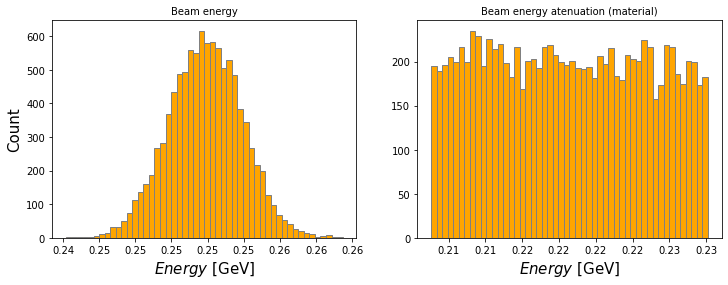

In [60]:
#Energy distributions
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

n, bins, _ = ax1.hist(E_cm_samples, bins=50,color='orange', ec='grey')
ax1.set_title('Beam energy', fontsize=10)
ax1.set_xlabel(r'$Energy$ [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
#ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax2.hist(a, bins=50,color='orange', ec='grey')
ax2.set_title('Beam energy atenuation (material)', fontsize=10)
ax2.set_xlabel(r'$Energy$ [GeV]', fontsize=15)
#ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [61]:
#Calculate the total momentum p       CM
#Calculate the momentum components in CM
p_cm_instances = np.sqrt(b**2/4-muon_mass**2)

pxm_cm = p_cm_instances * np.sin(theta_cm_instances)*np.cos(phi_cm_instances)
pym_cm = p_cm_instances * np.sin(theta_cm_instances)*np.sin(phi_cm_instances)
pzm_cm = p_cm_instances * np.cos(theta_cm_instances)

#Calculate the momentum components in LAB
vz = -np.sqrt(1-4*electron_mass**2/b**2)   
gamma = 1/np.sqrt(1-vz**2)

pxm_lb = pxm_cm
pym_lb = pym_cm
pzm_lb = gamma * pzm_cm - vz * gamma *b 

#Calculate the total momentum p       LAB
#Obtain the angles thet and phi       LAB
p_lb_instances = np.sqrt(pxm_lb**2 + pym_lb**2 + pzm_lb**2)

theta_lb_instances = np.arccos(pzm_lb/p_lb_instances)
phi_lb_instances   = np.arctan2(pym_lb,pxm_lb)

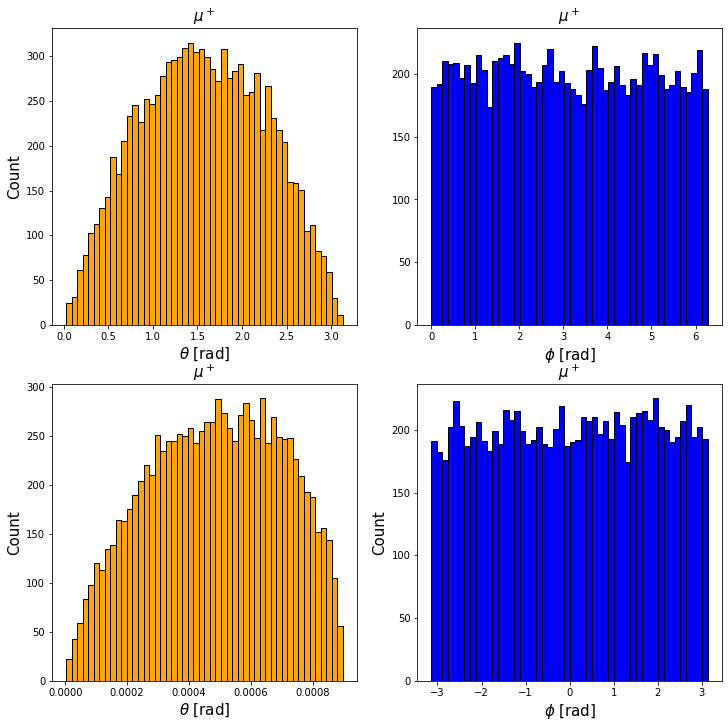

After undergoing a distance of one meter the beam has a cross section of 2.522704520645077 mm**2


In [62]:
#Plot of the spherical angle  distributions in each frame

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

n, bins, _ = ax1.hist(theta_cm_instances, bins=50,color='orange', ec='black')
ax1.set_title(r'$\mu^+$', fontsize=15)
ax1.set_xlabel(r'$\theta$ [rad]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
#ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

n, bins, _ = ax2.hist(phi_cm_instances, bins=50,color='blue', ec='black')
ax2.set_title(r'$\mu^+$', fontsize=15)
ax2.set_xlabel(r'$\phi$ [rad]', fontsize=15)
#ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

n, bins, _ = ax3.hist(theta_lb_instances, bins=50,color='orange', ec='black')
ax3.set_title(r'$\mu^+$', fontsize=15)
ax3.set_xlabel(r'$\theta$ [rad]', fontsize=15)
ax3.set_ylabel('Count', fontsize=15)
#ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

n, bins, _ = ax4.hist(phi_lb_instances, bins=50,color='blue', ec='black')
ax4.set_title(r'$\mu^+$', fontsize=15)
ax4.set_xlabel(r'$\phi$ [rad]', fontsize=15)
ax4.set_ylabel('Count', fontsize=15)
#ax4.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

plt.show()

print('After undergoing a distance of one meter the beam has a cross section of',np.pi*(np.sin(np.max(theta_lb_instances))*1000)**2,'mm**2')

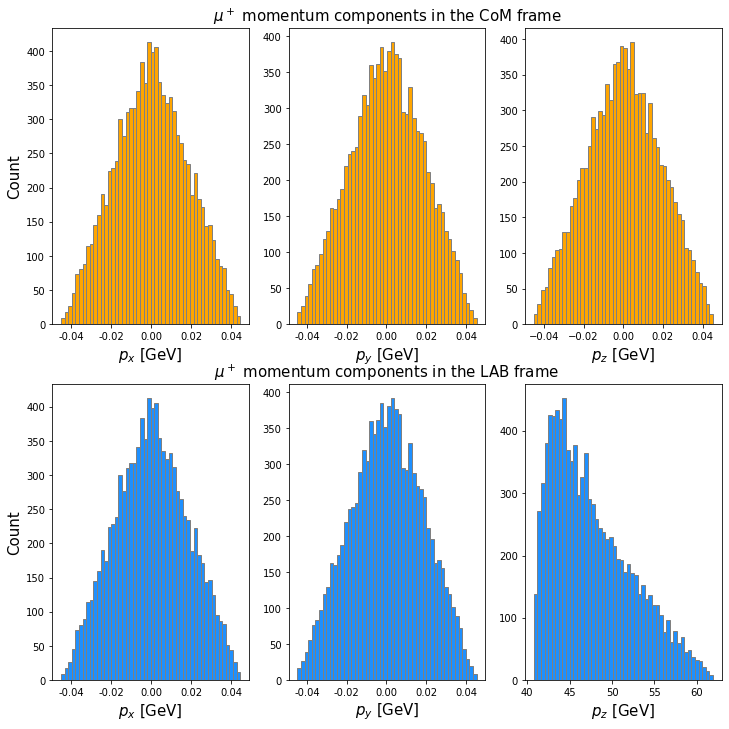

In [63]:
#Momentum distribution in the LAB frame
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))

n, bins, _ = ax1.hist(pxm_cm, bins=50,color='orange', ec='grey')
ax1.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax1.set_ylabel('Count', fontsize=15)
#ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax2.hist(pym_cm, bins=50,color='orange', ec='grey')
ax2.set_title(r'$\mu^+$ momentum components in the CoM frame', fontsize=15)
ax2.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
#ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



n, bins, _ = ax3.hist(pzm_cm, bins=50,color='orange', ec='grey')
ax3.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
#ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
#ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))


n, bins, _ = ax4.hist(pxm_lb, bins=50,color='dodgerblue', ec='grey')
ax4.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
ax4.set_ylabel('Count', fontsize=15)
#ax4.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


n, bins, _ = ax5.hist(pym_lb, bins=50,color='dodgerblue', ec='grey')
ax5.set_title(r'$\mu^+$ momentum components in the LAB frame', fontsize=15)
ax5.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
#ax5.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax5.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



n, bins, _ = ax6.hist(pzm_lb, bins=50,color='dodgerblue', ec='grey')
ax6.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
#ax6.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
#ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))



plt.show()

In [64]:
#Can we estimate the muons beams cross section? I think it's radius is 1 cm + 1mm
#1 cm from the positrons beam and 1 mm due to the scatering process.

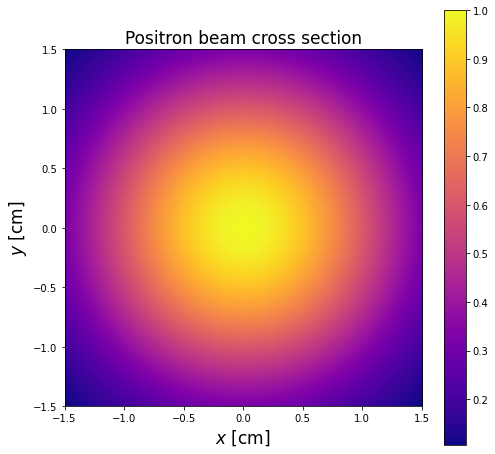

In [65]:
pixels=300
size  =(-1.5,1.5,-1.5,1.5)

# We randomly pick (pixel x pixels) elements of the energy distribution to plot the beam cross section
sigma=1
media =0.
x = np.linspace(-1.5, 1.5, pixels)
y = np.linspace(-1.5, 1.5, pixels)
xx, yy = np.meshgrid(x, y, sparse=True)

z = 3/(sigma * np.sqrt(2 * np.pi)) *np.exp( - ((xx - media)**2+(yy - media)**2) / (2 * sigma**2) )
z =z/np.max(z)

plt.rcParams["figure.figsize"] = (8,8)
plt.imshow(z,cmap='plasma', extent=(size),origin='lower')
plt.title('Positron beam cross section',fontsize=17)
plt.ylabel(r'${y}$ [cm]',fontsize=17)  
plt.xlabel(r'${x}$ [cm]',fontsize=17)
plt.colorbar()
#plt.clim(0,1)
plt.show()

In [66]:
############      ####      ###      ######
############      #####     ###      ### ###
###               ######    ###      ###  ### 
###               ### ###   ###      ###   ###
############      ###  ###  ###      ###    ###
############      ###   ### ###      ###     ###
###               ###    ## ###      ###    ###
###               ###     #####      ###   ###
############      ###      ####      ###  ###
############      ###       ###      ### ###
############################################